In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.stats import gaussian_kde
import pandas as pd
from sklearn.model_selection import train_test_split
from joblib import dump
from joblib import load
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import Input
from sklearn.metrics import r2_score,mean_absolute_error
import time
import sys


In [2]:
col_names = ['lon', 'lat', 'lai_hv', 'wind',
          'temperature', 'rain', 'pressure',
          'radiation', 'biomass']
mydir = './good_data/'
datadir = './finaldata/'
lai = np.load(mydir+"lai_hv_interp_congo_025.npy")
wind = np.load(mydir+"wind_interp_congo_025.npy")
temp = np.load(mydir+"temperature_interp_congo_025.npy")
rain = np.load(mydir+"rain_interp_congo_025.npy")
pres = np.load(mydir+"pressure_interp_congo_025.npy")
radi = np.load(mydir+"radiation_interp_congo_025.npy")
lon = np.load(mydir+"gedi_lon_congo_025.npy")
lat = np.load(mydir+"gedi_lat_congo_025.npy")
y = np.load(mydir+"gedi_agbd_congo_025.npy")

alldata = np.concatenate((lat.reshape(-1,1),lon.reshape(-1,1),lai.reshape(-1,1),\
                    wind.reshape(-1,1),temp.reshape(-1,1),rain.reshape(-1,1),\
                    pres.reshape(-1,1),radi.reshape(-1,1),y.reshape(-1,1)),axis=1)
alldata = alldata[~np.isnan(alldata).any(axis=1)] # remove nan

only run if you need to save alldata for hyperparameter tuning

In [ ]:
alldata = pd.DataFrame(alldata, columns=col_names)
print(alldata.shape)
pd.DataFrame(alldata).to_csv(datadir+'all_data.csv',index=False)

In [3]:
X = alldata[:,:-1] # split into X
y = alldata[:,-1] # split into y

sc_X = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))

fitted_X_scaled = sc_X.fit_transform(X)
fitted_y_scaled = sc_y.fit_transform(y.reshape(-1,1))

# stratified random sampling
n_strata = 20 # cover 0-99% percentiles, the rest is assigned to the last strata bin
strata_bins = np.full([n_strata],np.nan)
for j in range(n_strata):
    strata_bins[j] = np.percentile(fitted_y_scaled,99/n_strata*(j+1))
strata_y = np.full([len(fitted_y_scaled),1],0)
for j in range(len(fitted_y_scaled)):
    if fitted_y_scaled[j] <= strata_bins[0]:
        strata_y[j] = 1
    elif fitted_y_scaled[j] <= strata_bins[n_strata-1]:
        for k in range(n_strata-1):
            if fitted_y_scaled[j] <= strata_bins[k+1] and fitted_y_scaled[j] > strata_bins[k]:
                strata_y[j] = k+1
    else:
        strata_y[j] = n_strata-1

X_train,X_test,y_train,y_test = train_test_split(fitted_X_scaled,fitted_y_scaled,test_size=0.2,stratify=strata_y,random_state=0)

In [9]:
# Build model
layers = [8, 25, 15, 20, 24, 19, 1]
I = layers[0]
J = layers[-1]
nodes = layers[1:-1]
input_part1 = Input(shape=(I,))
ann_part1 = Dense(units=nodes[0], activation='relu')(input_part1)
ann_part1 = Dense(units=nodes[1], activation='relu')(ann_part1)
ann_part1 = Dense(units=nodes[2], activation='relu')(ann_part1)
ann_part1 = Dense(units=nodes[3], activation='relu')(ann_part1)
ann_part1 = Dense(units=nodes[4], activation='relu')(ann_part1)
ann_out = Dense(units=1, activation='linear')(ann_part1)
model = tf.keras.Model(inputs=input_part1, outputs=ann_out)
model.summary()

model.save('congo_ann.keras')

myepochs = 1000
mybatch_size = 10
#change
opt = tf.keras.optimizers.RMSprop(learning_rate=0.000086988854789057)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_12 (Dense)            (None, 25)                225       
                                                                 
 dense_13 (Dense)            (None, 15)                390       
                                                                 
 dense_14 (Dense)            (None, 20)                320       
                                                                 
 dense_15 (Dense)            (None, 24)                504       
                                                                 
 dense_16 (Dense)            (None, 19)                475       
                                                                 
 dense_17 (Dense)            (None, 1)                 20  

In [10]:
model.compile(optimizer = opt,loss = 'mse')

history = model.fit(X_train,y_train,\
              batch_size=mybatch_size,epochs=myepochs,\
              validation_data=(X_test,y_test))

Epoch 1/1000
202/202 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0191
Epoch 2/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.0182
Epoch 3/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0173 - val_loss: 0.0178
Epoch 4/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 5/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0164 - val_loss: 0.0171
Epoch 6/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0171
Epoch 7/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0169
Epoch 8/1000
202/202 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 9/1000
202/202 [==============================] - 1s 4ms/step - loss: 0.0157 - val_loss: 0.0167
Epoch 10/1000
202/202 [==============================] - 1s 5ms/step - loss: 0.015

63/63 [==============================] - 0s 2ms/step


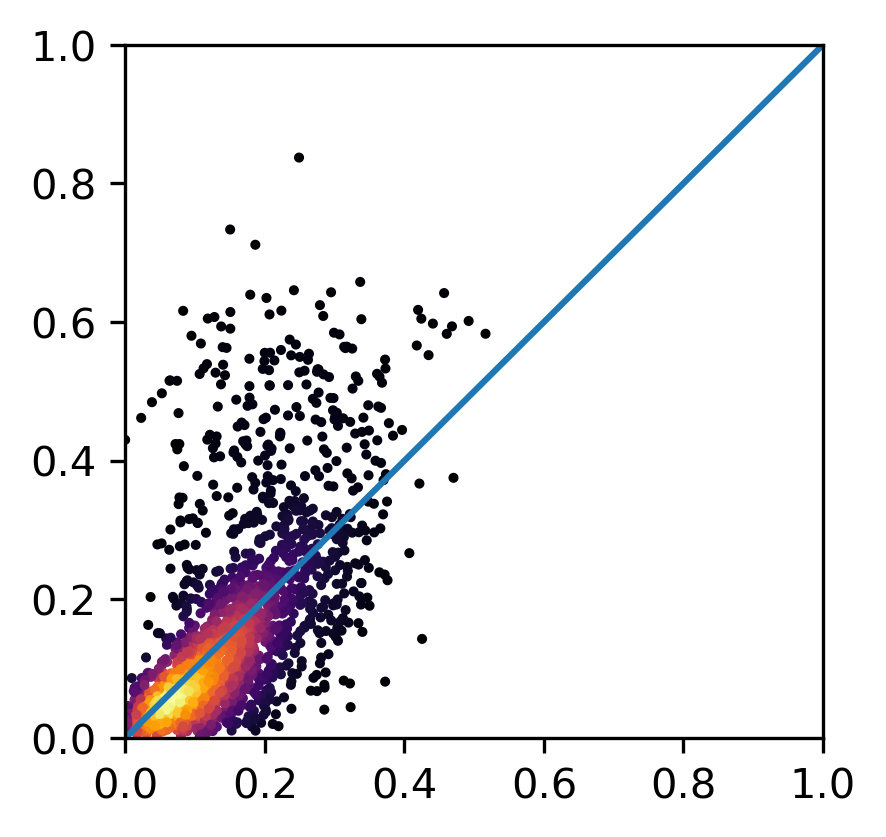

16/16 [==============================] - 0s 2ms/step


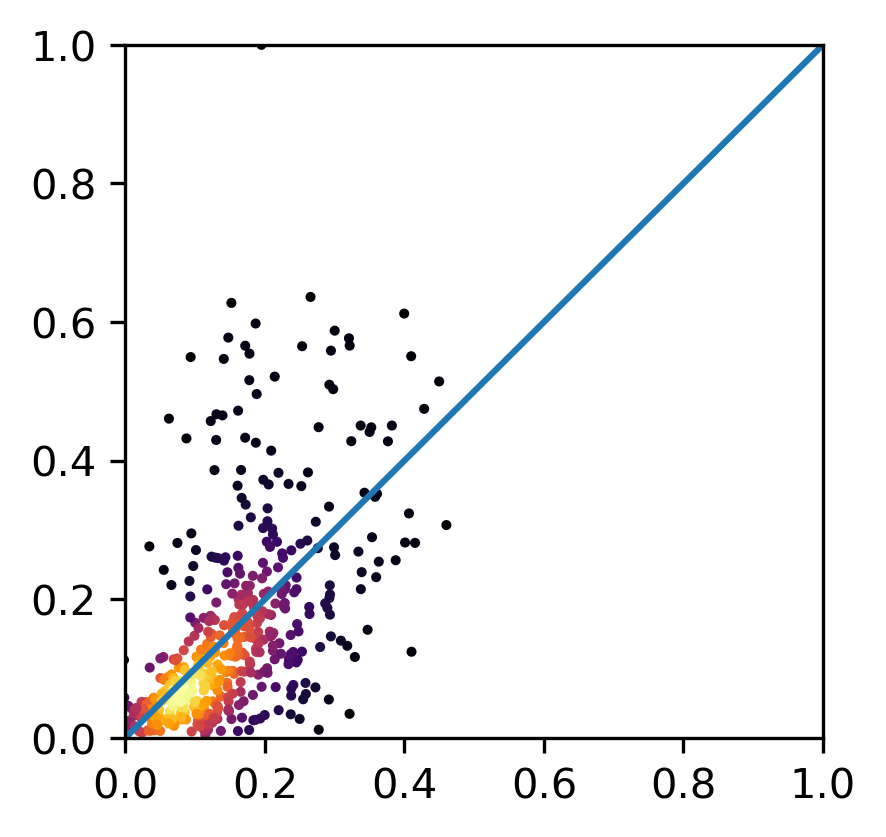

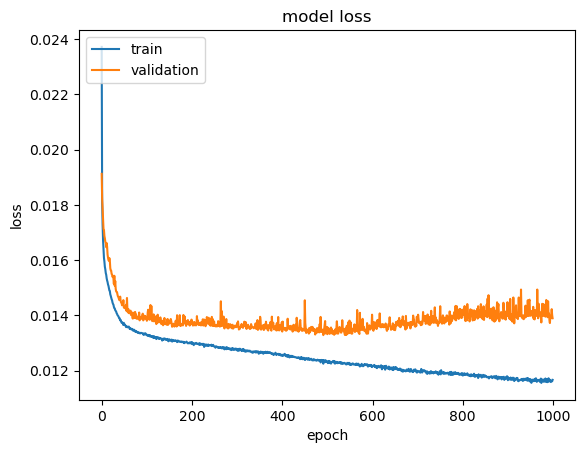

63/63 [==============================] - 0s 1ms/step
0.40024220956198286
16/16 [==============================] - 0s 2ms/step
0.3006702114421541


In [12]:
from matplotlib.pyplot import figure

#visualize
y_pred = model.predict(X_train)

# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_train.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#train
figure(figsize=(3,3), dpi=300)
plt.scatter(y_pred,y_train,label='Train',c=color,s=2,cmap='inferno')
plt.plot(range(0,2),range(0,2))
plt.xlim(0,1)
plt.ylim(0,1)
#plt.legend()
plt.show()

#test
y_pred = model.predict(X_test)
# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_test.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#test
figure(figsize=(3,3), dpi=300)
plt.scatter(y_pred,y_test,label='Test',c=color,s=2,cmap='inferno')
plt.plot(range(0,2),range(0,2))
plt.xlim(0,1)
plt.ylim(0,1)
#plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(r2_score(y_train,model.predict(X_train)))
print(r2_score(y_test,model.predict(X_test)))

In [11]:
amazondir = '../amazonCodes/'
#load amazon data
lai_a = np.load(amazondir+"lai_hv_interp_025.npy")
wind_a = np.load(amazondir+"wind_interp_025.npy")
temp_a = np.load(amazondir+"temperature_interp_025.npy")
rain_a = np.load(amazondir+"rain_interp_025.npy")
pres_a = np.load(amazondir+"pressure_interp_025.npy")
radi_a = np.load(amazondir+"radiation_interp_025.npy")
lon_a = np.load(amazondir+"gedi_lon_025.npy")
lat_a = np.load(amazondir+"gedi_lat_025.npy")
y_a = np.load(amazondir+"gedi_agbd_025.npy")

alldata2 = np.concatenate((lat_a.reshape(-1,1),lon_a.reshape(-1,1),lai_a.reshape(-1,1),\
                    wind_a.reshape(-1,1),temp_a.reshape(-1,1),rain_a.reshape(-1,1),\
                    pres_a.reshape(-1,1),radi_a.reshape(-1,1),y_a.reshape(-1,1)),axis=1)
alldata2 = alldata2[~np.isnan(alldata2).any(axis=1)] # remove nan

DON'T RUN UNLESS YOU NEED TO SAVE ALLDATA2 

In [ ]:
alldata2 = pd.DataFrame(alldata2, columns=col_names)
print(alldata2.shape)
pd.DataFrame(alldata2).to_csv(mydir+'all_data.csv',index=False)

Trial 9 finished with value: 0.01986623350530863 and parameters: {'n_layers': 9, 'activation': 'sigmoid', 'out_activation': 'relu', 'n_units_l0': 13, 'n_units_l1': 11, 'n_units_l2': 12, 'n_units_l3': 6, 'n_units_l4': 6, 'n_units_l5': 11, 'n_units_l6': 11, 'n_units_l7': 6, 'n_units_l8': 11, 'optimizer': 'SGD', 'SGD_learning_rate': 0.0001949024356366169}. Best is trial 4 with value: 0.014281144738197327.

Trial 40 finished with value: 0.014607313834130765 and parameters: {'n_layers': 9, 'activation': 'relu', 'out_activation': 'relu', 'n_units_l0': 13, 'n_units_l1': 9, 'n_units_l2': 9, 'n_units_l3': 14, 'n_units_l4': 13, 'n_units_l5': 13, 'n_units_l6': 12, 'n_units_l7': 11, 'n_units_l8': 9, 'optimizer': 'RMSprop', 'RMSprop_learning_rate': 0.0003769103165284093}. Best is trial 33 with value: 0.013559369742870331.

In [12]:
X = alldata2[:,:-1] # split into X
y = alldata2[:,-1] # split into y

fitted_X_scaled = sc_X.transform(X)
fitted_y_scaled = sc_y.transform(y.reshape(-1,1))

# stratified random sampling
n_strata = 20 # cover 0-99% percentiles, the rest is assigned to the last strata bin
strata_bins = np.full([n_strata],np.nan)
for j in range(n_strata):
    strata_bins[j] = np.percentile(fitted_y_scaled,99/n_strata*(j+1))
strata_y = np.full([len(fitted_y_scaled),1],0)
for j in range(len(fitted_y_scaled)):
    if fitted_y_scaled[j] <= strata_bins[0]:
        strata_y[j] = 1
    elif fitted_y_scaled[j] <= strata_bins[n_strata-1]:
        for k in range(n_strata-1):
            if fitted_y_scaled[j] <= strata_bins[k+1] and fitted_y_scaled[j] > strata_bins[k]:
                strata_y[j] = k+1
    else:
        strata_y[j] = n_strata-1

X_train,X_test,y_train,y_test = train_test_split(fitted_X_scaled,fitted_y_scaled,test_size=0.2,stratify=strata_y,random_state=0)

In [14]:
layers = len(model.layers)

#set all but the last 3 layers as untrainable
for i in range (layers-2):
    model.layers[i].trainable = False
    
#model.compile(optimizer = opt,loss = 'mse')

history_amazon = model.fit(X_train,y_train,\
              batch_size=mybatch_size,epochs=myepochs,\
              validation_data=(X_test,y_test))

Epoch 1/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0602 - val_loss: 0.0157
Epoch 2/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 3/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0132 - val_loss: 0.0146
Epoch 4/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0144
Epoch 5/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0129 - val_loss: 0.0141
Epoch 6/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0127 - val_loss: 0.0142
Epoch 7/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0141
Epoch 8/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0139
Epoch 9/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0140
Epoch 10/1000
1017/1017 [==============================] - 1s 1m

63/63 [==============================] - 0s 1ms/step


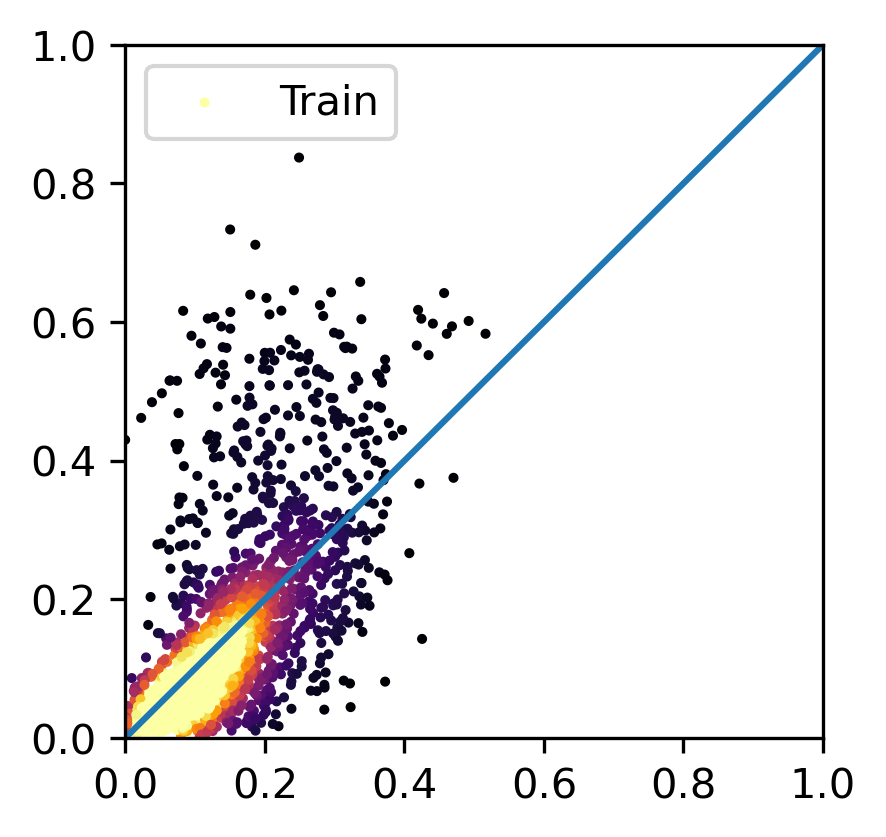

16/16 [==============================] - 0s 2ms/step


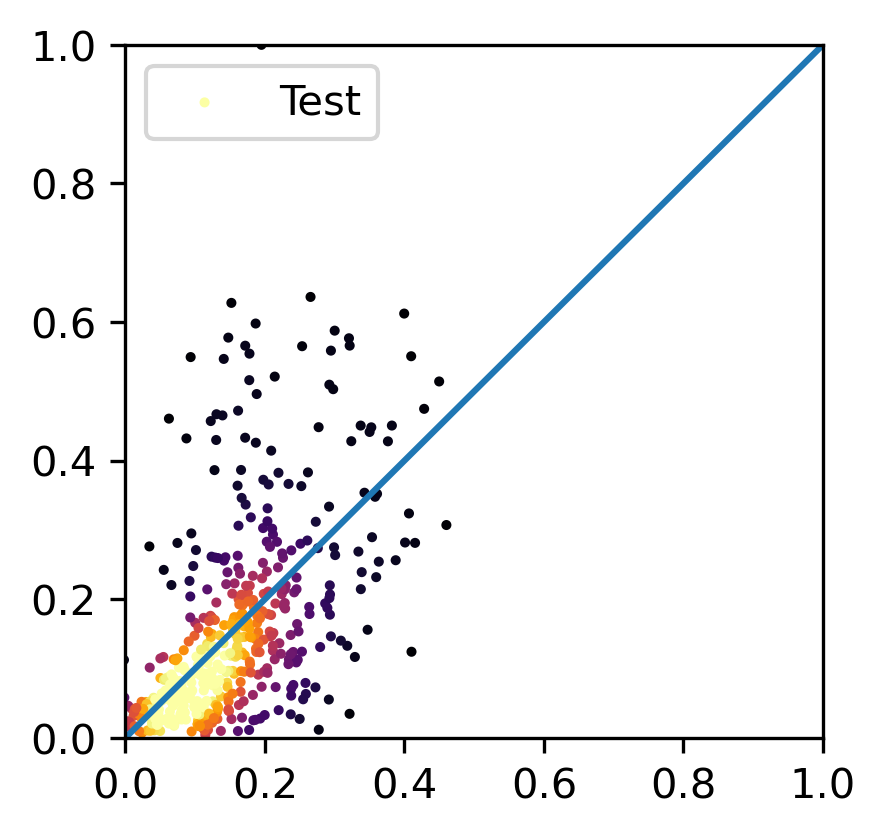

NameError: name 'history_amazon' is not defined

In [15]:
#visualize
y_pred = model.predict(X_train)

# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_train.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#train
figure(figsize=(3,3), dpi=300)
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(y_pred,y_train,label='Train',c=color,s=2,cmap='inferno')
plt.plot(range(0,2),range(0,2))
plt.legend()
plt.show()

#test
y_pred = model.predict(X_test)
# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_test.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#test
figure(figsize=(3,3), dpi=300)
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(y_pred,y_test,label='Test',c=color,s=2,cmap='inferno')
plt.plot(range(0,2),range(0,2))
plt.legend()
plt.show()

plt.plot(history_amazon.history['loss'])
plt.plot(history_amazon.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0.01,0.025)
plt.show()

print(r2_score(y_train,model.predict(X_train)))
print(r2_score(y_test,model.predict(X_test)))

In [13]:
print(color)

[25.41259007  8.63823179 23.42828068  7.79983652  3.26290132 22.38228928
 17.53408896  3.00480969 25.70960483 17.49692577  1.54802572 25.91522527
  3.21554007 14.08027055 25.38381657  8.60884778 20.50272405  0.39611992
  8.42747209  1.20334341  3.20699064 21.83879989 14.76780412  3.17771116
  7.98929205  5.17275079 22.4728812  16.23856619 17.1148785  15.91703252
  3.52740292  8.56907622 13.49745782 19.60133927 19.37293519 22.42101698
 17.81833515  1.0432364  10.99295339 16.29231488  3.42530271 16.00668675
 21.9942696  19.66793233  8.06009888  6.85049021 18.1680992  23.60741827
 11.36899956  9.51195181 14.24351154  8.37861582 23.38727667 16.55806571
  1.25987966 12.892199   24.24672474 19.8543888   9.84411713 21.30147142
  0.60171679 23.05020003 16.38949523  1.91753617 19.90231211 10.31493636
 14.5749855  16.89353803  9.16684215 18.87902006  0.54566226  1.67475907
 22.79973966  4.11487096 17.10042426  0.93103568 16.50715926 18.00593995
 15.99052164  6.61115871  2.00342602 10.61837575 20

In [38]:
print(sum(y_a < 0))

0
